<a href="https://colab.research.google.com/github/AmulPatil/Case-Studies/blob/master/Classification_of_MNIST_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #transforms.ToPILImage(),
                                       transforms.RandomRotation(degrees = (-10,10), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=256)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0061)
 - std: tensor(1.0077)
 - var: tensor(1.0155)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([256, 1, 28, 28])
torch.Size([256])


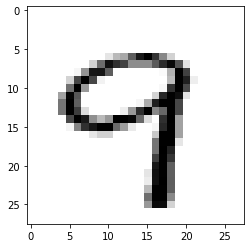

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = test.train_data
train_data = test.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

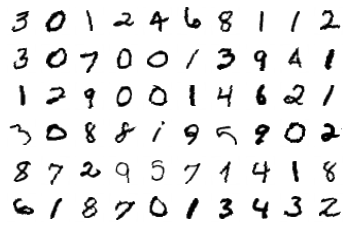

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 12

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 10
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            #nn.ReLU()
        ) # output_size = 1
       
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]             512
      BatchNorm2d-11           [-1, 16, 12, 12]              32
             ReLU-12           [-1, 16, 12, 12]               0
          Dropout-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    # Update pbar-tqdm
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    print("EPOCH:", epoch)
    scheduler.step(epoch)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    test(model, device, test_loader)

Loss=0.26354190707206726 Batch_id=234 Accuracy=93.81: 100%|██████████| 235/235 [00:10<00:00, 21.81it/s]

EPOCH: 0
Epoch: 0 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9802/10000 (98.02%)



Loss=0.060532186180353165 Batch_id=234 Accuracy=97.48: 100%|██████████| 235/235 [00:10<00:00, 22.05it/s]

EPOCH: 1
Epoch: 1 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9819/10000 (98.19%)



Loss=0.07184430211782455 Batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:10<00:00, 21.74it/s]

EPOCH: 2
Epoch: 2 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9890/10000 (98.90%)



Loss=0.02933170460164547 Batch_id=234 Accuracy=98.18: 100%|██████████| 235/235 [00:10<00:00, 21.93it/s]

EPOCH: 3
Epoch: 3 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)



Loss=0.012065132148563862 Batch_id=234 Accuracy=98.21: 100%|██████████| 235/235 [00:10<00:00, 21.99it/s]

EPOCH: 4
Epoch: 4 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9892/10000 (98.92%)



Loss=0.05928098037838936 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:10<00:00, 21.79it/s]

EPOCH: 5
Epoch: 5 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9916/10000 (99.16%)



Loss=0.007849082350730896 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:10<00:00, 22.14it/s]

EPOCH: 6
Epoch: 6 LR: [0.0010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9920/10000 (99.20%)



Loss=0.012017528526484966 Batch_id=234 Accuracy=98.68: 100%|██████████| 235/235 [00:10<00:00, 21.90it/s]

EPOCH: 7
Epoch: 7 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)



Loss=0.05241316929459572 Batch_id=234 Accuracy=98.74: 100%|██████████| 235/235 [00:10<00:00, 22.24it/s]

EPOCH: 8
Epoch: 8 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)



Loss=0.03708599880337715 Batch_id=234 Accuracy=98.77: 100%|██████████| 235/235 [00:10<00:00, 22.29it/s]

EPOCH: 9
Epoch: 9 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)



Loss=0.13633155822753906 Batch_id=234 Accuracy=98.77: 100%|██████████| 235/235 [00:10<00:00, 22.00it/s]

EPOCH: 10
Epoch: 10 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)



Loss=0.05448673665523529 Batch_id=234 Accuracy=98.79: 100%|██████████| 235/235 [00:10<00:00, 22.50it/s]


EPOCH: 11
Epoch: 11 LR: [0.010000000000000002]


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)



Loss=0.025461941957473755 Batch_id=234 Accuracy=98.80: 100%|██████████| 235/235 [00:10<00:00, 21.94it/s]

EPOCH: 12
Epoch: 12 LR: [0.00010000000000000003]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)



Loss=0.01249213982373476 Batch_id=234 Accuracy=98.85: 100%|██████████| 235/235 [00:10<00:00, 22.12it/s]

EPOCH: 13
Epoch: 13 LR: [0.0010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)



Loss=0.021252742037177086 Batch_id=234 Accuracy=98.78: 100%|██████████| 235/235 [00:10<00:00, 22.39it/s]

EPOCH: 14
Epoch: 14 LR: [0.0010000000000000002]



Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

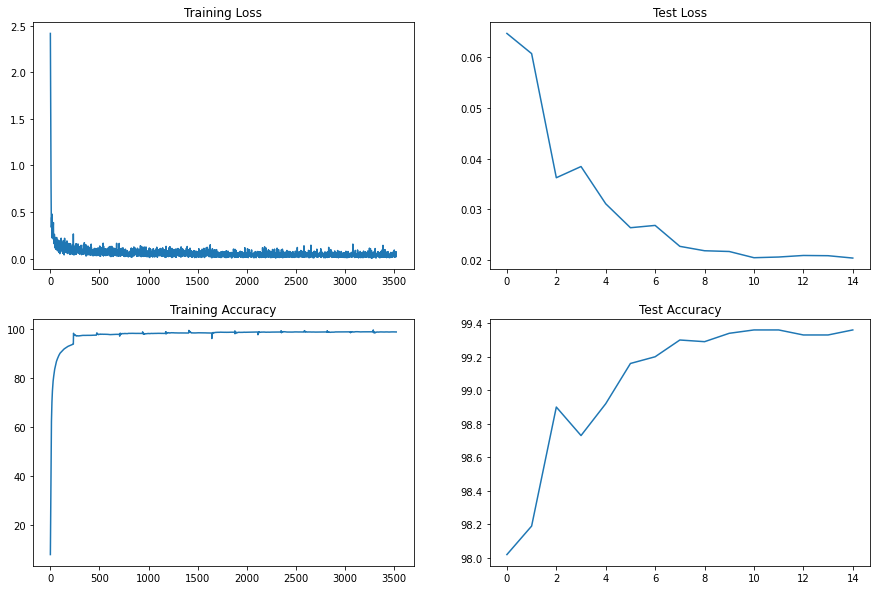

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")